In [51]:
Copyright (c) [2018] [Prabhash Kumar Jha and Isheeta Jha] 

using Images
using PyPlot
using JLD
using Base.Test


# Transform from Cartesian to homogeneous coordinates
function cart2hom(points::Array{Float64,2})
  return [points; ones(1,size(points,2))]::Array{Float64,2}
end


# Transform from homogeneous to Cartesian coordinates
function hom2cart(points::Array{Float64,2})
  res = points[1:end-1,:] ./ points[end:end,:]
  return res::Array{Float64,2}
end


# Translation by v
function gettranslation(v::Array{Float64,1})
  T = eye(4)
  T[1:3,4] = v
  return T::Array{Float64,2}
end



# Rotation of d degrees around x axis
function getxrotation(d::Int)
   Rx = eye(4);
   Rx[2:3,2:3] = [cos(pi*d/180) -sin(pi*d/180); sin(pi*d/180) cos(pi*d/180)]  
  return Rx::Array{Float64,2}
end


# Rotation of d degrees around y axis
function getyrotation(d::Int)
   Ry = eye(4);
   Ry[[1 3],[1 3]] = [cos(pi*d/180) sin(pi*d/180); -sin(pi*d/180) cos(pi*d/180)]  
   return Ry::Array{Float64,2}
end


# Rotation of d degrees around z axis
function getzrotation(d::Int)
  Rz = eye(4);
  Rz[1:2,1:2] = [cos(pi*d/180) -sin(pi*d/180); sin(pi*d/180) cos(pi*d/180)]  
  return Rz::Array{Float64,2}
end


# Central projection matrix (including camera intrinsics)
function getcentralprojection(principal::Array{Int,1}, focal::Int)
   K=[focal 0.0 principal[1] 0; 0.0 focal principal[2] 0; 0.0 0.0 1.0 0] 
  return K::Array{Float64,2}
end



# Return full projection matrix P and full model transformation matrix M
function getfullprojection(T::Array{Float64,2},Rx::Array{Float64,2},Ry::Array{Float64,2},Rz::Array{Float64,2},V::Array{Float64,2})
   M=Rz*Rx*Ry*T
   P = V*M
  return P::Array{Float64,2},M::Array{Float64,2}
end


# Load 2D points
function loadpoints()
   path="obj2d.jld"
   points = JLD.load(path,"x")
  return points::Array{Float64,2}
end


# Load z-coordinates
function loadz()
    path="zs.jld"
    z = JLD.load(path,"Z")  #loads a single row with 2904 elements
  return z::Array{Float64,2}
end


# Invert just the central projection P of 2d points *P2d* with z-coordinates *z*
function invertprojection(P::Array{Float64,2}, P2d::Array{Float64,2}, z::Array{Float64,2})
      # P  centralproj  P2dpoints   z is z coordinate
      K = P[:,1:3] #  camera intrinsic matrix
      P3d=inv(K)*cart2hom(P2d)  
      P3d=P3d.*z  ## gives proper scale to d points
   return P3d::Array{Float64,2}
end


# Invert just the model transformation of the 3D points *P3d*
function inverttransformation(A::Array{Float64,2}, P3d::Array{Float64,2})
      X = A \ cart2hom(P3d)
    return X::Array{Float64,2}
end

# Plot 2D points
function displaypoints2d(points::Array{Float64,2})
  display(points[1,:])
  display(points[2,:])
  figure()
  plot(points[1,:],points[2,:],".b")
    
  title("2d display") 
  xlabel("2D Image X")
  ylabel("2D Image Y")
 return nothing
end


# Plot 3D points
function displaypoints3d(points::Array{Float64,2})
  figure()
  scatter3D(points[1,:],points[2,:],points[3,:],".b")
  xlabel("3D X")
  ylabel("3D Y")
  zlabel("3D Z")
  title("3d display")
  return nothing
end


# Apply full projection matrix *C* to 3D points *X*
function projectpoints(P::Array{Float64,2}, X::Array{Float64,2})
    P2d=P*cart2hom(X)
    P2d=hom2cart(P2d)
    return P2d::Array{Float64,2}
end


###Projective Transformation #
# parameters
t               = [-27.1; -2.9; -3.2]
principal_point = [8; -10]
focal_length    = 8

# model transformations
T = gettranslation(t)
Ry = getyrotation(135)
Rx = getxrotation(-30)
Rz = getzrotation(90)
display(T)
display(Ry)
display(Rx)
display(Rz)



4×4 Array{Float64,2}:
 1.0  0.0  0.0  -27.1
 0.0  1.0  0.0   -2.9
 0.0  0.0  1.0   -3.2
 0.0  0.0  0.0    1.0

4×4 Array{Float64,2}:
 -0.707107  0.0   0.707107  0.0
  0.0       1.0   0.0       0.0
 -0.707107  0.0  -0.707107  0.0
  0.0       0.0   0.0       1.0

4×4 Array{Float64,2}:
 1.0   0.0       0.0       0.0
 0.0   0.866025  0.5       0.0
 0.0  -0.5       0.866025  0.0
 0.0   0.0       0.0       1.0

4×4 Array{Float64,2}:
 6.12323e-17  -1.0          0.0  0.0
 1.0           6.12323e-17  0.0  0.0
 0.0           0.0          1.0  0.0
 0.0           0.0          0.0  1.0

In [52]:
# central projection including camera intrinsics
K = getcentralprojection(principal_point,focal_length)

display(K)

# full projection and model matrix
P,M = getfullprojection(T,Rx,Ry,Rz,K)
display(P)
display(M)



3×4 Array{Float64,2}:
 8.0  0.0    8.0  0.0
 0.0  8.0  -10.0  0.0
 0.0  0.0    1.0  0.0

3×4 Array{Float64,2}:
 -2.07055   -10.9282  -2.07055    94.4295
  0.46687     5.0     11.7806    -64.85  
 -0.612372   -0.5     -0.612372   20.0049

4×4 Array{Float64,2}:
  0.353553  -0.866025      0.353553  -8.20119
 -0.707107   5.30288e-17   0.707107  16.8999 
 -0.612372  -0.5          -0.612372  20.0049 
  0.0        0.0           0.0        1.0    

2904-element Array{Float64,1}:
  1.03812  
 -0.677855 
 -1.28088  
 -1.16545  
 -1.03465  
 -0.979845 
 -1.37066  
 -1.27098  
 -1.15583  
 -1.05518  
 -1.00022  
 -1.15406  
 -1.29446  
  ⋮        
  2.57921  
  0.0403098
  2.25597  
 -0.149209 
  2.01452  
 -0.311763 
  1.65226  
 -0.489898 
  1.38341  
 -0.669206 
  1.0939   
 -0.976042 

2904-element Array{Float64,1}:
 -1.40967 
 -0.970208
  0.305549
  0.125537
 -0.108528
 -0.311005
  0.281575
  0.107977
 -0.145416
 -0.324385
 -0.471493
 -0.331816
 -0.140747
  ⋮       
 -2.68984 
 -1.60998 
 -2.59702 
 -1.59134 
 -2.52826 
 -1.56779 
 -2.42884 
 -1.54082 
 -2.35999 
 -1.50673 
 -2.28448 
 -1.43452 

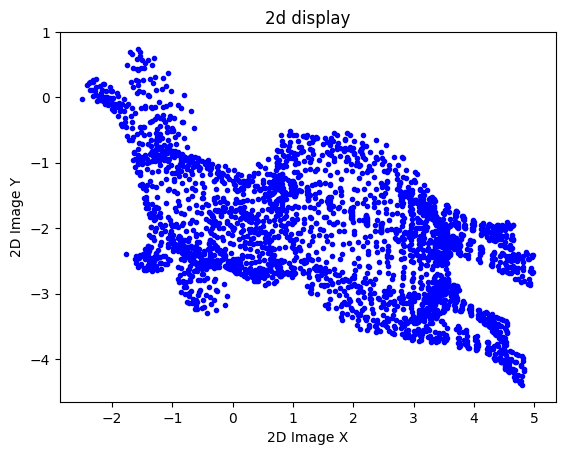

In [53]:
# load data and plot it
points = loadpoints()

displaypoints2d(points)


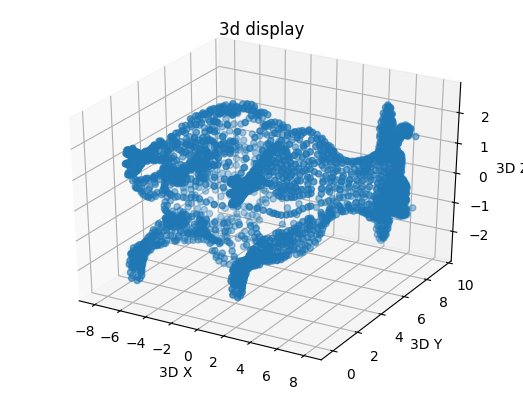

In [54]:
# reconstruct 3d scene
z = loadz()
Xt = invertprojection(K,points,z)

Xh = inverttransformation(M,Xt)

worldpoints = hom2cart(Xh)
displaypoints3d(worldpoints)



2904-element Array{Float64,1}:
  1.03812  
 -0.677855 
 -1.28088  
 -1.16545  
 -1.03465  
 -0.979845 
 -1.37066  
 -1.27098  
 -1.15583  
 -1.05518  
 -1.00022  
 -1.15406  
 -1.29446  
  ⋮        
  2.57921  
  0.0403098
  2.25597  
 -0.149209 
  2.01452  
 -0.311763 
  1.65226  
 -0.489898 
  1.38341  
 -0.669206 
  1.0939   
 -0.976042 

2904-element Array{Float64,1}:
 -1.40967 
 -0.970208
  0.305549
  0.125537
 -0.108528
 -0.311005
  0.281575
  0.107977
 -0.145416
 -0.324385
 -0.471493
 -0.331816
 -0.140747
  ⋮       
 -2.68984 
 -1.60998 
 -2.59702 
 -1.59134 
 -2.52826 
 -1.56779 
 -2.42884 
 -1.54082 
 -2.35999 
 -1.50673 
 -2.28448 
 -1.43452 

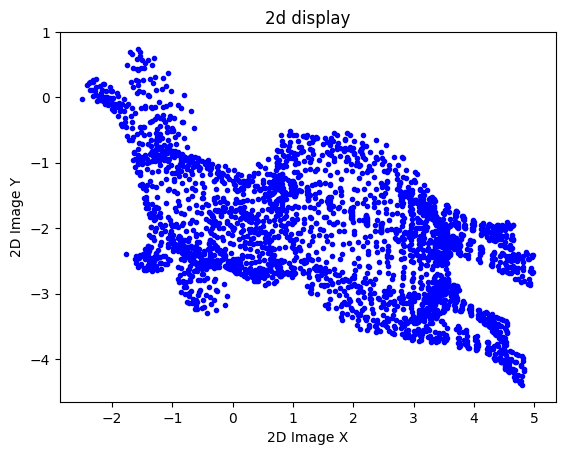

3.432647996454634e-27

In [55]:
# reproject points to verify if we are back to same points in 2D
points2 = projectpoints(P,worldpoints)
displaypoints2d(points2)

# @test_approx_eq points points2
err = sum((points - points2).^2)